In [27]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [7]:
df_test = pd.read_csv("/content/drive/My Drive/datasetTPDatos/test.csv")
df_train = pd.read_csv("/content/drive/My Drive/datasetTPDatos/train.csv")
#Elimino duplicados
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [8]:
#Definición de tipos
df_train['id'] = df_train['id'].astype(int)
df_train['keyword'] = df_train['keyword'].fillna(value = "noKeyword").astype('object')
df_train['location'] = df_train['location'].astype('object')
df_train['text'] = df_train['text'].astype('object')
df_train['target'] = df_train['target'].astype('bool')
df_test['id'] = df_test['id'].astype(int)
df_test['keyword'] = df_test['keyword'].fillna(value = "noKeyword").astype('object')
df_test['location'] = df_test['location'].astype('object')
df_test['text'] = df_test['text'].astype('object')

df_test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [9]:
df_train_res = df_train.copy()
df_test_res = df_test.copy()

In [10]:
def clean_text(text):
  text = re.sub('[=><.,;\']', '',text)
  text = re.sub('(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+/(?:[-\w.]|(?:%[\da-fA-F]{2}))+', 'URL',text)
  return text

In [11]:
from nltk.tokenize import TweetTokenizer

def pre_process_text(text):
  tokenizer = TweetTokenizer(reduce_len=True,strip_handles=False)
  processed_text = text.lower()
  processed_text = clean_text(processed_text)
  processed_text = tokenizer.tokenize(processed_text)
  processed_text = ' '.join(processed_text)
    
  return processed_text

In [12]:
#Pre limpieza:
df_train_res.head(5)

,id,keyword,location,text,target
0,1,noKeyword,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,noKeyword,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,noKeyword,NaN,All residents asked to 'shelter in place' are ...,True
3,6,noKeyword,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,noKeyword,NaN,Just got sent this photo from Ruby #Alaska as ...,True


In [13]:
df_train_res['text'] = df_train_res['text'].apply(lambda x : pre_process_text(x))
df_test_res['text'] = df_test_res['text'].apply(lambda x : pre_process_text(x))

In [14]:
#Post limpieza
df_train_res.head(5)

,id,keyword,location,text,target
0,1,noKeyword,NaN,our deeds are the reason of this #earthquake m...,True
1,4,noKeyword,NaN,forest fire near la ronge sask canada,True
2,5,noKeyword,NaN,all residents asked to shelter in place are be...,True
3,6,noKeyword,NaN,13000 people receive #wildfires evacuation ord...,True
4,7,noKeyword,NaN,just got sent this photo from ruby #alaska as ...,True


In [15]:
# --------------- NLP - Manipulación  del texto --------------- #
#Idea 1 : Limpiar las stopwords y hacer un contador de entidades importantes (ej nombre paises, personas famosas, etc)

#Contador de palabras que no son stopwords

import spacy #Para Named Entity Recognition
from spacy import displacy #Para Named Entity Recognition
from collections import Counter #Para Named Entity Recognition
import en_core_web_sm #Para Named Entity Recognition
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
sw = stopwords.words("english")
tknz = TweetTokenizer(reduce_len=True, strip_handles=False)
nlp = en_core_web_sm.load()
catastrophe = df_train_res['keyword'].loc[df_train_res['keyword'] != 'noKeyword'].drop_duplicates().apply(lambda x: re.sub('%20', ' ',x))

def contains_location(text):
  count = 0
  words = nlp(re.sub('#','',text))
  for X in words.ents:
    if X.label_ in ['FAC','GPE','LOC']:
      count += 1
  return count

def count_no_stopwords(text):
  count = 0
  words = word_tokenize(text)
  for w in words:
    if w not in sw:
      count +=1
  return count

def text_size_word(text):
  words = tknz.tokenize(text)
  return len(words)
  
def lemmatize_catastrophe(text):
  count = 0
  words = tknz.tokenize(text)
  #lemmatizer = WordNetLemmatizer()
  for w in words:
    if re.sub('#','',w) in catastrophe.to_list():
      count += 1
  return count

def count_url_per_tw(text):
  count = 0
  words = tknz.tokenize(text)
  if 'URL' in words:
    for w in words:
      if w == 'URL':
        count +=1
  return count/len(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
#Me quedo con columnas que me interesan
df_train_res = df_train_res.loc[:,['id','text','target','keyword']]
df_test_res = df_test_res.loc[:,['id','text']]
#df_train_res

In [17]:
# ---------------Creación de features --------------- #

# --------------------------------- Train ------------------------------------ #
largos = df_train_res['text'].apply(text_size_word) #cant words por text
df_train_res['count_words'] = largos
# --- Idea 1 ---
df_train_res['num_no_stopwords'] = df_train_res['text'].apply(count_no_stopwords)
# --- Combino Idea 1 con count_words (hago la division)
df_train_res['no_stpw / count_words'] = df_train_res['num_no_stopwords'] / df_train_res['count_words']

# --- Idea 2 --- #
df_train_res['count_catastrophe'] = df_train_res['text'].apply(lemmatize_catastrophe)

# --- Idea 3 --- # Aplicar algun tipo de TF-IDF para descartar textos como "wreck wreck wreck wreck wreck " porque no aportan nada
# --- Idea 4 --- # Contiene paises / nombres famosos ?? (Booleano)
# --- Idea 5 --- # Contains

df_train_res['contains_location'] = df_train_res['text'].apply(contains_location)
df_train_res['count_url'] = df_train_res['text'].apply(count_url_per_tw)

In [ ]:
# --------------------------------- Test ------------------------------------- #

largos = df_test_res['text'].apply(text_size_word) #cant words por text
df_test_res['count_words'] = largos
# --- Idea 1 ---
df_test_res['num_no_stopwords'] = df_test_res['text'].apply(count_no_stopwords)
# --- Combino Idea 1 con count_words (hago la division)
df_test_res['no_stpw / count_words'] = df_test_res['num_no_stopwords'] / df_test_res['count_words']

# --- Idea 2 --- #
df_test_res['count_catastrophe'] = df_test_res['text'].apply(lemmatize_catastrophe)

# --- Idea 3 --- # Aplicar algun tipo de TF-IDF para descartar textos como "wreck wreck wreck wreck wreck " porque no aportan nada
# --- Idea 4 --- # Contiene paises / nombres famosos ?? (Booleano)
# --- Idea 5 --- # Contains
# --- Idea 6 --- # "Lemmatize count", darle un peso inicial 0 a X feature, y si aparece ese mismo o alguna palabra similar que tenga mismo lemmatize, sumarle 1

df_test_res['contains_location'] = df_test_res['text'].apply(contains_location)
df_test_res['count_url'] = df_test_res['text'].apply(count_url_per_tw)

In [18]:
feature_arr = ['count_words','num_no_stopwords','no_stpw / count_words','count_catastrophe','contains_location','count_url']

In [ ]:
# -------------- Definición de train y test set - MLP (submit) --------------- #

y_train = np.array(df_train_res['target']) # prediction 
X_train = df_train_res.copy()  #Train submit
X_test = df_test_res.copy()
X_train_clf = X_train.loc[:,feature_arr] #Features del train
X_test_clf = X_test.loc[:,feature_arr] #Features del test
prints = (len(X_train_clf), len(y_train), len(X_test_clf))
print(prints) 

In [19]:
# --------------- Definición de train y test set local - MLP - (train spliteado en train2.0 y test porque no tengo target test) --------------- #

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
#X = np.array(X) #Esto se hace si tengo 1 solo feature
X = df_train_res.copy() #Train local
y = np.array(df_train_res['target']) # prediction 
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_train_clf = X_train.loc[:,feature_arr] #Features del train
#X_train_clf = preprocessing.scale(X_train_clf) #Standarization, or mean removal and variance scaling para agilizar el entrenamiento pero me baja mucho el accuracy 
X_test_clf = X_test.loc[:,feature_arr] #Features del test
prints = (len(X_train) , len(X_test) , len(y_train) , len(y_test), y)
print(prints) 

(5709, 1904, 5709, 1904, array([ True,  True,  True, ...,  True,  True,  True]))


In [20]:
# --------------- Entrenamiento - MLP (Multilayer Perceptron) --------------- #
clf = MLPClassifier(activation='relu',learning_rate_init=0.0003, hidden_layer_sizes=(50,35), random_state=1, max_iter=200, solver='adam')
#X_train = X_train.reshape(-1, 1) #Esto se hace si tengo 1 solo feature
clf.fit(X_train_clf, y_train) 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 35), learning_rate='constant',
              learning_rate_init=0.0003, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [21]:
# --------------- Prediccion y score - MLP --------------- #
pred = clf.predict(X_test_clf)

In [22]:
clf.score(X_test_clf,y_test)

0.7116596638655462

In [ ]:
def convertStates(x):
    if(x == True):
        return 1
    else:
        return 0

In [ ]:
from google.colab import files
predict = pd.DataFrame()
predict['id'] = X_test['id']
predict['target'] = pred
predict['target'] = predict['target'].apply(convertStates)
predict.to_csv('result.csv',index=False)
files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# --------------- Comparación - Test vs Predict local - MLP --------------- #
result = X_test.loc[:,['id','text','target']]
result['prediction'] = pred
diff = result.loc[result['target'] != result['prediction']]
diff

,id,text,target,prediction
3472,4967,young dancer moves about 300 youth in attendan...,True,False
1388,2001,so apparently there were bush fires near where...,True,False
4314,6126,fel lord zakuun is about to die ! #hellfire #w...,True,False
3237,4649,just saw a car on the i - 77 fully engulfed in...,True,False
6918,9920,trouble trouble when i dont get my way ? ? ?,False,True
...,...,...,...,...
5089,7256,@dalailama then have the biggest nuclear disas...,True,False
4494,6391,hurricane guillermo live noaa tracking / loopi...,True,False
4144,5891,imagine a doctor treating an #ebola patient wi...,True,False
6724,9636,severe thunderstorm warning including russellv...,True,False


In [ ]:
nlp = en_core_web_sm.load()
words = nlp(re.sub('#','',df_train_res.loc[4021,'text']))
print([(X.text, X.label_) for X in words.ents])

print(df_train_res.loc[4021,'text'])
print(df_train.loc[4021,'text'])

words = nlp(re.sub('#','',df_train_res.loc[4021,'text'].upper()))
count = 0
for X in words.ents:
  if X.label_ in ['FAC','GPE','LOC']:
    count += 1
print(count)

[('beaverton forest grove', 'ORG')]
be careful anyone who lives west of beaverton forest grove has a rapidly spreading fire heading east
BE CAREFUL anyone who lives west of Beaverton. Forest Grove has a rapidly spreading fire heading east
0


In [24]:
df_train_res.loc[4494,'text']

'hurricane guillermo live noaa tracking / looping wedaug 5th ~ URL ~ URL URL'

In [49]:
df_train_res.iloc[4044]

id                                                                    5744
text                     a little concerned about the number of forest ...
target                                                                True
keyword                                                     forest%20fires
count_words                                                             13
num_no_stopwords                                                         7
no_stpw / count_words                                             0.538462
count_catastrophe                                                        0
contains_location                                                        0
count_url                                                                0
Name: 4044, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_train_res['text'])
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(vectorizer.get_feature_names())

['00', '000', '00pm', '01', '012', '014', '02', '0215', '025', '03', '030', '032', '033', '034', '039', '039monster', '04', '045', '05', '05082015', '05th', '06', '060', '061', '066gp', '06jst', '07', '075', '08', '080515', '0840728', '0853', '08780923344', '0880', '09', '097', '0fsloths', '0npzp', '0sed', '10', '100', '1000', '1000s', '1008pla', '1008planet', '100bn', '100mb', '100nd', '100s', '101', '1017', '1023', '1028', '103', '105', '106', '1061', '1061thetwister', '107', '1079', '109', '10am', '10k', '10km', '10m', '10news', '10pm', '10th', '10w', '10x', '11', '11000', '111020', '112', '113', '114', '1141', '1145', '115', '115film', '119000', '11am', '12', '1200', '12000', '12022', '123', '1236', '124', '12413172', '125', '129', '12hr', '12jst', '12m', '12mm', '12news', '12th', '12u', '12v', '13', '130', '13000', '133', '138', '14', '140', '14000', '14028', '141', '143', '148', '149', '14th', '15', '150', '1500', '15000270364', '15000270653', '158', '159', '15901', '15km', '15mo

In [3]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-08-01 20:26:06--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.251.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.251.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  43.9MB/s    in 37s     

2020-08-01 20:26:43 (42.5 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [1]:
!pip install gensim
from gensim.models import KeyedVectors

In [4]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [7]:
def cos(x1, x2):
  return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

In [22]:
#Jugando con word2vec
cos(word2vec['coronavirus'],word2vec['pandemic'])
word2vec.most_similar(positive=['car','crash'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('accident', 0.6770085096359253),
 ('wreck', 0.6625399589538574),
 ('vehicle', 0.6519672274589539),
 ('SUV', 0.6443443298339844),
 ('Driver_flees', 0.6319849491119385),
 ('driver', 0.6299632787704468),
 ('Biker_dies', 0.6203857660293579),
 ('Motorist_dies', 0.6154729127883911),
 ('minvan', 0.6148028373718262),
 ('rear_ender', 0.6093763709068298)]

In [ ]:
pred

In [ ]:
#--------- Prediccion-------
#pred = pd.DataFrame()
#pred['id'] = df_test['id']
#pred_data = model.predict(df_test_x)
#pred['target'] = pred_data.tolist()
#pred['target'] = pred['target'].apply(lambda x : convertStates(x))

In [25]:
#Random forest de rama
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
le = preprocessing.LabelEncoder()

#df_train["text"] = le.fit_transform(df_train['text'])
#df_train["target"] = le.fit_transform(df_train["target"])
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0) 

regressor.fit(X_train_clf,y_train)

Y_pred = regressor.predict(X_test_clf)  # test the output by changing values 
print(Y_pred)

[1.         0.82       0.36747619 ... 1.         0.07579458 0.2267409 ]


In [26]:
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=400)
#tree.plot_tree(regressor.estimators_[0], feature_names = X_train_clf.columns, filled = True);

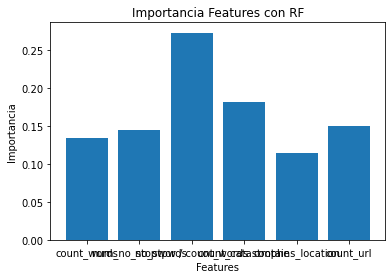

In [27]:
plt.bar(X_train_clf.columns, regressor.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [28]:
X_train_clf.columns

Index(['count_words', 'num_no_stopwords', 'no_stpw / count_words',
       'count_catastrophe', 'contains_location', 'count_url'],
      dtype='object')

In [ ]:
#csv de randomforest
from google.colab import files
pred = pd.DataFrame()
pred['id'] = X_test['id']
pred['target'] = Y_pred.tolist()
pred['target'] = pred['target'].apply(lambda x : round(x))
pred.to_csv('resultRFWF.csv',index=False)
files.download('resultRFWF.csv')